In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Classe "Gaussian Bundle", vaidée dans Voting_Gaussians

In [2]:
class GaussianBundle:
    """Class Gaussian Bundle
    - modélise une Gaussienne (avec vecteur moyenne et matrice de covariance)
    - inclut un compteur de datapoints reliés à la Gaussienne
    """
    
    def __init__(self, mu, sigma, ctr=None):
        """constructeur

        Args:
            mu (array of length D): vecteur moyenne
            sigma (array of shape DxD): matrice de covariance. Supposée définie positive.
        """
        
        self.D = mu.shape[0]
        self.mu = mu
        self.sigma = sigma
        if ctr==None:
            self.ctr = 0
        else:
            self.ctr = ctr
        
    def add_point(self, x):
        """ajoute point à la Gaussienne :
        - update mu et covariance
        - ajoute 1 au compteur

        Args:
            x (array of length D): nouveau point
        """
        
        # mini test de dimension
        assert x.shape[0] == self.D, "nouveau point de dimension différente de la Gaussienne de rattachement"
        
        # update vecteur moyenne mu
        n = self.ctr
        mu_n = self.mu 
        self.mu = mu_n * n / (n+1) + 1 / (n+1) * x # calcul mu_n+1
        
        # update covariance
        sigma_n = self.sigma
        self.sigma = n/(n+1) * sigma_n + n/(n+1)**3 * np.matmul((x-mu_n).reshape(self.D,1), (x-mu_n).reshape(1,self.D) ) + 1/(n+1) * np.matmul( (x-self.mu).reshape(self.D,1), (x-self.mu).reshape(1,self.D))
        
        # incrémente compteur
        self.ctr += 1
        
    
    def __str__(self):
        msg = "Gaussian bundle \n" + f"Dimension {self.D} \n" + f"mu = {self.mu} " + f"cov = {self.sigma} \n" + f'points assignés = {self.ctr}'
        return msg
    
    def __repr__(self):
        msg = "Gaussian bundle \n" + f"Dimension {self.D} \n" + f"mu = {self.mu} " + f"cov = {self.sigma} \n" + f'points assignés = {self.ctr}'
        return msg

In [5]:
def calcul_parametres(liste_points):
    """calcul mu et sigma sur une liste de points 2D"""
    
    points = np.array(liste_points)
    # print(points)
    D = points.shape[-1]
    # print(D)
    mu = np.mean( np.array(liste_points), axis=0 )
    # print(mu)
    sigma = 0
    for i in range(len(liste_points)):
        point = points[i]
        sigma = sigma + np.matmul( (point-mu).reshape(D,1), (point-mu).reshape(1,D))
    sigma = 1/len(liste_points) * sigma
        
    return mu, sigma 

# Comparatif GMM vs Voting Gaussians

### Génération dataset

In [199]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.67
K = 3
pi_gaussiennes = [(1-p_noise)/K] * K

In [200]:
N_POINTS = 5000
points = np.zeros(shape=(N_POINTS,2))
labels = np.zeros(shape=(N_POINTS))
choices = np.arange(K)

# create Gaussians
mus = np.random.uniform(low=-1.0, high=1.0, size=(K,2))
sigma_max = 0.05
covs = np.zeros(shape=(K,2,2))

for i in range(K):
    diag = np.array( [ [np.random.uniform(low=0.0, high=sigma_max),0], [0, np.random.uniform(low=0.0, high=sigma_max)] ] )
    theta = np.random.uniform(low=0, high=2*np.pi)
    ortho = np.array( [ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    covs[i] = np.matmul( np.transpose(ortho), np.matmul(diag, ortho) )

In [201]:
rng = np.random.default_rng()

for i in range(N_POINTS):
    p = np.random.uniform()
    if p <= p_noise:
        point = np.random.uniform(low=-1.0-sigma_max*3, high=1+sigma_max*3, size=2)
        label = -1
    else:
        n_gaussienne = np.random.choice(choices)
        label = n_gaussienne
        mu = mus[n_gaussienne]
        sigma = covs[n_gaussienne]
        point = rng.multivariate_normal(mean=mu, cov=sigma)
    points[i] = point
    labels[i] = label

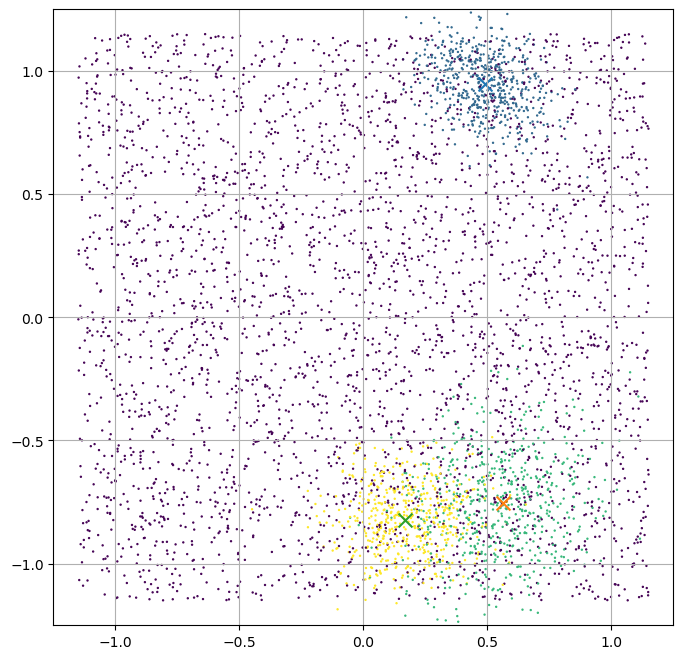

In [202]:
fig, ax  = plt.subplots(figsize=(8,8))

ax.scatter(points[:,0], points[:,1], c=labels, marker='.', s=2.0, alpha=1.0)
ax.set_xlim(left=-1.0-sigma_max*5, right=1+sigma_max*5)
ax.set_ylim(bottom=-1.0-sigma_max*5, top=1+sigma_max*5)
ax.grid(True)
for i in range(K):
    ax.scatter(mus[i,0], mus[i,1], label=f'Gaussienne {K}', s=100.0, marker='x')
plt.show()

### Baseline : Bayesian Gaussian Mixture sur tout le dataset

In [203]:
from sklearn.mixture import BayesianGaussianMixture

In [204]:
dpbgm = BayesianGaussianMixture(
    n_components = K*3, # max number of components, will be infered by data
    weight_concentration_prior_type = 'dirichlet_process',   # weight concentration prior is Dirchlet process : (approximate) infinite number of components
    random_state = 42,
    reg_covar = 1e-6,
    verbose = 3,
    max_iter = 1000,
)

dpbgm.fit(points)

Initialization 0


  Iteration 10	 time lapse 0.49072s	 ll change 1.51012
  Iteration 20	 time lapse 0.43851s	 ll change 0.56121
  Iteration 30	 time lapse 0.35990s	 ll change 0.33747
  Iteration 40	 time lapse 0.29662s	 ll change 0.23032
  Iteration 50	 time lapse 0.50891s	 ll change 0.14923
  Iteration 60	 time lapse 0.45438s	 ll change 0.08886
  Iteration 70	 time lapse 0.30099s	 ll change 0.05584
  Iteration 80	 time lapse 0.26262s	 ll change 0.03883
  Iteration 90	 time lapse 0.34532s	 ll change 0.02836
  Iteration 100	 time lapse 0.40584s	 ll change 0.02091
  Iteration 110	 time lapse 0.26342s	 ll change 0.01545
  Iteration 120	 time lapse 0.32220s	 ll change 0.01153
  Iteration 130	 time lapse 0.39086s	 ll change 0.00881
  Iteration 140	 time lapse 0.50134s	 ll change 0.00694
  Iteration 150	 time lapse 0.36261s	 ll change 0.00565
  Iteration 160	 time lapse 0.28327s	 ll change 0.00473
  Iteration 170	 time lapse 0.28269s	 ll change 0.00405
  Iteration 180	 time lapse 0.30844s	 ll change 0.00352
 

BayesianGaussianMixture(max_iter=1000, n_components=9, random_state=42,
                        verbose=3)

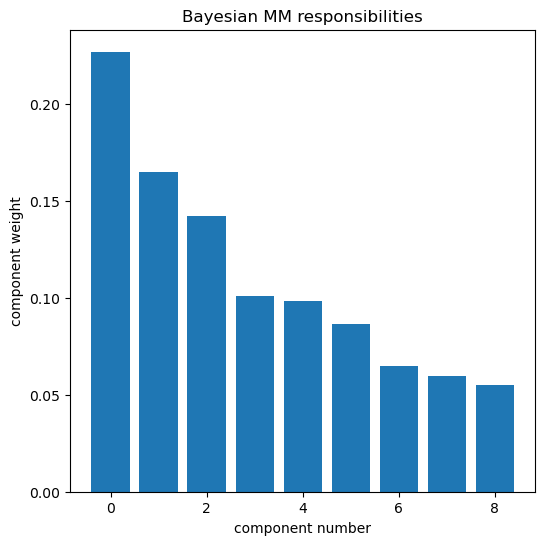

In [205]:
comp_number = [ x for x in range(K*3) ]
responsibilities = sorted(list(dpbgm.weights_),reverse=True)

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(comp_number, responsibilities)
ax.set_xlabel('component number')
ax.set_ylabel('component weight')
# ax.set_yscale("log")
ax.set_title(f'Bayesian MM responsibilities')
plt.show()

In [206]:
idx = np.argpartition(dpbgm.weights_, -K)[-K:]  # indices des plus K grandes responsabilités
resp = dpbgm.weights_[idx]

In [207]:
print('Responsabilités dataset :')
print(pi_gaussiennes)
print(f'Top {K} responsabilités inférées par le modèle :')
print(resp)

Responsabilités dataset :
[0.10999999999999999, 0.10999999999999999, 0.10999999999999999]
Top 3 responsabilités inférées par le modèle :
[0.14253328 0.16481461 0.22711532]


In [208]:
print(f'Moyennes des {K} gaussiennes du dataset :')
print(np.sort(mus[:K], axis=0))
print(f'Moyennes des {K} gaussiennes inférées par le modèle :')
print(np.sort(dpbgm.means_[idx], axis=0))

Moyennes des 3 gaussiennes du dataset :
[[ 0.16866236 -0.82323022]
 [ 0.489456   -0.75212468]
 [ 0.56381467  0.94535308]]
Moyennes des 3 gaussiennes inférées par le modèle :
[[-0.00226729 -0.82529787]
 [ 0.24187749  0.04029143]
 [ 0.48481607  0.94450016]]
